# InceptionV3 on Cifar10 dataset

#### Importing the necessary Libraries

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score,log_loss
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Dense,Flatten, GlobalAveragePooling2D
from keras import models,losses,optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3,VGG16,resnet50
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

#### Loading the data and performing inbuilt pre-processing

In [2]:
from tensorflow.keras.datasets import cifar10
(X_train,y_train),(X_test,y_test) = cifar10.load_data()
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train).toarray().astype(int)
y_test = ohe.transform(y_test).toarray().astype(int)

170500096/170498071 [==============================] - 2s 0us/step


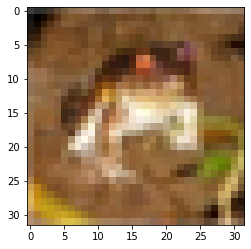

In [5]:
plt.imshow(X_train[0])

#### Function to resize the input image
    - Intitial size : (32x32)
    - Final size : (139x139)

In [0]:
def resize_data(data):
  data_upscaled = []
  for i, img in enumerate(data):
    large_img = cv2.resize(img, dsize=(139, 139))
    data_upscaled.append(large_img)
  return data_upscaled

In [7]:
X_train = np.array(resize_data(X_train))
X_test = np.array(resize_data(X_test)) 
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
print( X_train.shape, y_train.shape,  X_test.shape, y_test.shape )

(50000, 139, 139, 3) (50000, 10) (10000, 139, 139, 3) (10000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


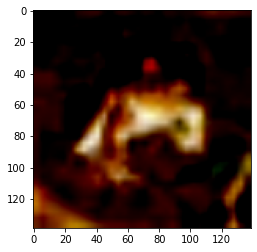

In [8]:
plt.imshow(X_train[0])

#### Model Building

In [9]:
base = InceptionV3(include_top = False,weights='imagenet',input_shape = (139,139,3))
model = models.Sequential()
model.add(base)
model.add(GlobalAveragePooling2D())
model.add(Dense(4096, activation='relu', name='Dense_Intermediate'))
model.add(Dropout(0.5, name='Dropout_Regularization'))
model.add(Dense(10, activation='softmax', name='Output'))

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
for cnnlayer in model.layers[0].layers:
    cnnlayer.trainable = False
model.layers[0].trainable = False

In [0]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
Dense_Intermediate (Dense)   (None, 4096)              8392704   
_________________________________________________________________
Dropout_Regularization (Drop (None, 4096)              0         
_________________________________________________________________
Output (Dense)               (None, 10)                40970     
Total params: 30,236,458
Trainable params: 8,433,674
Non-trainable params: 21,802,784
_________________________________________________________________


In [13]:
model.fit(X_train,y_train,epochs=10,batch_size=500,validation_data=(X_test,y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 158s 3ms/step - loss: 2.4186 - accuracy: 0.4971 - val_loss: 1.0465 - val_accuracy: 0.7195
Epoch 2/10
50000/50000 [==============================] - 142s 3ms/step - loss: 1.0825 - accuracy: 0.6365 - val_loss: 1.8638 - val_accuracy: 0.6324
Epoch 3/10
50000/50000 [==============================] - 142s 3ms/step - loss: 0.9447 - accuracy: 0.6788 - val_loss: 1.4949 - val_accuracy: 0.6679
Epoch 4/10
50000/50000 [==============================] - 142s 3ms/step - loss: 0.8561 - accuracy: 0.7069 - val_loss: 1.4933 - val_accuracy: 0.6914
Epoch 5/10
50000/50000 [==============================] - 141s 3ms/step - loss: 0.7824 - accuracy: 0.7306 - val_loss: 1.9663 - val_accuracy: 0.6788
Epoch 6/10
50000/50000 [==============================] - 141s 3ms/step - loss: 0.7344 - accuracy: 0.7476 - val_loss: 1.3527 - val_accuracy: 0.7430
Epoch 7/10
50000/50000 [==============================] - 141s

#### Performance Evaluation

In [15]:
y_pred = model.predict(X_test)
y_pred = y_pred.round().astype(int)
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [16]:
classwise_precision = precision_score(y_test,y_pred, average=None)
for i in range(len(classwise_precision)):
  print("Precision for class {} = {}".format(i,classwise_precision[i]))
print("Mean Precision = ",classwise_precision.mean())

Precision for class 0 = 0.7765640516385303
Precision for class 1 = 0.862475442043222
Precision for class 2 = 0.9433962264150944
Precision for class 3 = 0.7538677918424754
Precision for class 4 = 0.7976878612716763
Precision for class 5 = 0.7192342752962625
Precision for class 6 = 0.8074596774193549
Precision for class 7 = 0.640203932993445
Precision for class 8 = 0.7753001715265866
Precision for class 9 = 0.7981308411214953
Mean Precision =  0.7874320271568143


In [17]:
classwise_recall = recall_score(y_test,y_pred, average=None)
for i in range(len(classwise_recall)):
  print("Recall for class {} = {}".format(i,classwise_recall[i]))
print("Mean Recall = ",classwise_recall.mean())

Recall for class 0 = 0.782
Recall for class 1 = 0.878
Recall for class 2 = 0.55
Recall for class 3 = 0.536
Recall for class 4 = 0.552
Recall for class 5 = 0.789
Recall for class 6 = 0.801
Recall for class 7 = 0.879
Recall for class 8 = 0.904
Recall for class 9 = 0.854
Mean Recall =  0.7525000000000002


In [18]:
print("Log Loss = ",log_loss(y_test,y_pred))

Log Loss =  7.61027399085463
